# Task 1.2 Data Preparation
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to process the data

In [192]:
import math
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn import decomposition

We set pandas options


In [193]:
pd.set_option('mode.use_inf_as_na', True) #Set the inf values as pd.NA
pd.set_option('max_info_rows',12_000_000)

Then we load the cleaned dataset adn the users datset

In [194]:
# Load cleaned joined dataset
df_cleaned = pd.read_csv('../dataset/cleaned_joined_tweets.csv', sep=',', index_col=0)
# Load cleaned users dataset\
df_users = pd.read_csv('../dataset/cleaned_users.csv', sep=',', index_col=0) 

In [195]:
df_users.rename(columns={'id':'user_id'}, inplace=True)

Then we cast the columns to the proper datatypes

In [196]:
df_cleaned.created_at = pd.to_datetime(df_cleaned.created_at)
df_cleaned.text = df_cleaned.text.astype('string')
df_cleaned.lang = pd.Categorical(df_cleaned.lang)

df_users.created_at = pd.to_datetime(df_users.created_at)
df_users.lang = pd.Categorical(df_users.lang)

In [197]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11508 non-null  int64         
 1   lang            11508 non-null  category      
 2   bot             11508 non-null  int64         
 3   created_at      11508 non-null  datetime64[ns]
 4   statuses_count  11508 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(3)
memory usage: 461.5 KB


In [198]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11277758 entries, 0 to 11277757
Data columns (total 14 columns):
 #   Column           Non-Null Count     Dtype         
---  ------           --------------     -----         
 0   user_id          11277758 non-null  int64         
 1   id               10901728 non-null  float64       
 2   retweet_count    11277758 non-null  int64         
 3   reply_count      11277758 non-null  int64         
 4   favorite_count   11277758 non-null  int64         
 5   num_hashtags     11277758 non-null  int64         
 6   num_urls         11277758 non-null  int64         
 7   num_mentions     11277758 non-null  int64         
 8   created_at       11277758 non-null  datetime64[ns]
 9   text             10860709 non-null  string        
 10  lang             11277758 non-null  category      
 11  bot              11277758 non-null  int64         
 12  created_at_user  11277758 non-null  object        
 13  statuses_count   11277758 non-null  int6

## Plot graphics and correlation map

## Extracting indicators
Indicators per user covered: 

*   tweet_count
*   avg_text_len
*   tweet_with_text_count
*   entropy_second
*   entropy_minute
*   entropy_15minutes
*   entropy_hour
*   entropy_day
*   retweet_count_avg
*   reply_count_avg
*   favorite_count_avg
*   num_hashtags_avg
*   num_urls_avg
*   num_mentions_avg
*   retweet_count_sum
*   reply_count_sum
*   favorite_count_sum
*   num_hashtags_sum
*   num_urls_sum
*   num_mentions_sum

# Functions used to extract indicators


Function to determine if the tweet is outside of possible publishing years.

It is delimited between the 2006, the creation year of twitter and 2020, the year of the data crawling

TODO: NON L'ABBIAMO INSERITA, SI ELIMINA?

In [199]:
min_date = np.datetime64('2006-07-15 00:00:00') # Twitter creation year, used to check if a tweet is published after the creation of twitter
max_date = np.datetime64('2020-12-31 23:59:59') # Data scraping year, used to check if a tweet is published before the data scraping

def get_tweet_outside_of_possible_publishing_years(tweet):
    if tweet.created_at < min_date or tweet.created_at > max_date:  # if the tweet is outside of the publishable period of time
        return 1
    else:
        return 0

Function that calculates how many tweets each user has.

In [200]:
def extract_tweet_count(df):
    # Groupby user and count occurrences ('text' is just a placeholder attribute to do the count on)
    df_count = df[['user_id', 'text']].groupby(by='user_id').count()

    df_count.rename(columns={'text':'tweet_count'}, inplace=True)
    df_count.reset_index(inplace=True)
    
    return df_count

### Numeric tweet attributes function indicators functions

Function that calculates the sum of tweet attributes values for all of the user tweets

In [201]:
def sum_attributes(df, df_indicators):
    # Group by user and sum attributes
    df_sum = df.groupby(by='user_id').sum()

    df_sum.rename(columns = lambda col : str(col)+'_sum', inplace=True)
    df_sum.reset_index(inplace=True)
    
    # Merge dataframe of attributes sum with previous indicators column
    return df_indicators.merge(df_sum, on='user_id', how='left')


Function that calculates average tweet attribute value for user (es: average number of hashtags in a tweet).

(float) = *sum_attribute_values / num_user_tweets*

In [202]:
def avg_attributes(df, df_indicators):
    # Groupby user and average on attributes 
    df_avg = df.groupby(by='user_id').mean()

    df_avg.rename(columns = lambda col : str(col)+'_avg', inplace=True)
    df_avg.reset_index(inplace=True)
    
    # Merge dataframe of average attributes with previous indicators column
    return df_indicators.merge(df_avg, on='user_id', how='left')


In [203]:
def year_count(df, df_indicators):
    #Get a groupby with the count of posts 
    df_years = df.groupby([df.user_id, df.created_at.dt.year], as_index=False).size()
    df_years = df_years.pivot_table('size','user_id','created_at')
    df_years.reset_index(drop=False, inplace=True)
    df_years = df_years.rename_axis(None, axis=1)
    
    years_outside_of_plausible_range = list(range(1953,1961))+list(range(2032,2041))
    df_years['years_outside_of_plausible_range'] = df_years.loc[:,years_outside_of_plausible_range].sum(axis=1)
    df_years.drop(df_years.loc[:,years_outside_of_plausible_range], axis=1, inplace=True)
    df_years.columns = [f'post_in_{i}' if i not in ['user_id', 'years_outside_of_plausible_range'] else f'{i}' for i in df_years.columns]
    df_years.fillna(0, inplace=True)
    df_years = df_years.convert_dtypes()

    return df_indicators.merge(df_years, on='user_id', how='left')

In [259]:
def creation_year(df_indicators):
    df_indicators['creation_year'] = pd.DatetimeIndex(df_indicators.created_at).year
    return df_indicators

### Text indicators functions

Function that calculates the average tweet text lenght for each user

In [204]:
def avg_tweet_length(df, df_indicators):
    # Groupby user and average on text length 
    df_text_avg_len = df[['user_id', 'text_len']].groupby(by='user_id').mean()

    df_text_avg_len.reset_index(inplace=True)
    df_text_avg_len.rename(columns={'text_len':'avg_text_len'}, inplace=True)

    # Merge average text lenght dataframe with previous indicators column
    return df_indicators.merge(df_text_avg_len, on='user_id', how='left')

In [205]:
def count_tweets_with_text(df, df_indicators):
    # Select rows with text_len>0, then groupby user and count the occurrences of those rows for each user
    df_tweet_with_text_count = df[['user_id', 'text_len']].loc[df.text_len != 0].groupby(by='user_id').count()
    # Doing this, users with only tweets with text_len=0 will be excluded from the new grouped dataframe

    df_tweet_with_text_count.reset_index(inplace=True)
    df_tweet_with_text_count.rename(columns={'text_len':'tweet_with_text_count'}, inplace=True)

    # Left join with df_indicators in order not to lose users with only 0 length tweet.
    # Those users will have NaN instead of the count of non-zero lenght tweets
    df_indicators_joined = df_indicators.merge(df_tweet_with_text_count, on='user_id', how='left')
    # Fill those NaNs with 0
    df_indicators_joined.tweet_with_text_count.fillna(value=0, inplace=True)
    
    return df_indicators_joined


#### Entropy extraction functions

get_entropy_dict_from_timedeltas is a function that give the dictionary 'dict_of_dict_of_timedeltas', it calculates the entropy of each user.

'dict_of_dict_of_timedeltas' is in the form of  n*{user_id : m*{timedelta_i : number of times timedelta_i has been encountered}} where there are n users and m category of timedelta.

In [206]:
#The threshold is needed to consider a meaningful number of tweets for applying the entropy
entropy_threshold = 10

def get_entropy_dict_from_timedeltas(dict_of_dict_of_timedeltas):
    entropy_dict = dict()
    for user_id in tqdm(dict_of_dict_of_timedeltas,desc='Getting user\'s entropy from timedeltas',total=len(dict_of_dict_of_timedeltas)):
        dict_of_timedeltas_of_the_user = dict_of_dict_of_timedeltas[user_id]
        total_number_of_timedeltas = sum(dict_of_timedeltas_of_the_user.values()) #the total number of timedeltas appeared
        if total_number_of_timedeltas >= entropy_threshold:
            entropy = 0. #entropy set to 0.
            for timedelta in dict_of_timedeltas_of_the_user:
                number_of_timedelta = dict_of_timedeltas_of_the_user[timedelta] #the number of times the unique timedelta has appeared
                #The probability of a timedelta to appear is the number of times the unique timedelta has appeared over total number of times timedeltas appeared
                entropy -= number_of_timedelta/total_number_of_timedeltas * np.log2(number_of_timedelta/total_number_of_timedeltas) #shannon's entropy

            entropy_dict[user_id] = entropy
        else:
            entropy_dict[user_id] = np.nan
    return entropy_dict

apply_time_precision convert the timedelta to the desired precision specified by 'time_precision'.

'time_precision' could be: 'seconds', 'minute', '15minutes', 'hour', 'day'.

In [207]:
def apply_time_precision(timedelta, time_precision='second'):
    if time_precision=='minute':
        return timedelta.round(freq='min') # approximate to nearest minute
    elif time_precision=='15minutes':
        return timedelta.round(freq='15min') # approximate to nearest 15 minutes
    elif time_precision=='hour':
        return timedelta.round(freq='h') # approximate to nearest hour
    elif time_precision=='day': 
        return timedelta.round(freq='D') # approximate to nearest day
    else:
        return timedelta.round(freq='s') # # approximate to nearest second (default)

get_timedelta_list_per_user generate the dictionary 'dict_of_dict_of_timedeltas' to get the entropies from.

In [208]:
def get_timedelta_list_per_user(time_precision='second'):
    df_cleaned.sort_values(by="created_at",inplace=True) # is needed to be sorted by date in order to be able to subtract the previous date from the current

    last_tweet_encountered = dict() #a dict where the key is user_id and the value is the last post datetime64. It is needed to get the timedelta between posts
    tweet_timedeltas = dict() #a dict where the key is user_id and the value is a dict containing the timedeltas:number_of_times_timedelta_encountered

    for _, tweet in tqdm(df_cleaned.iterrows(),desc='Getting timedeltas list with '+time_precision+' precision', total=len(df_cleaned)): #iterating on rows
        try: #if user_id cannot be casted into int64 it skips the tweet
            user_id = np.int64(tweet['user_id'])
        except:
            continue

        if user_id not in tweet_timedeltas.keys(): # if user is not into the timedeltas
            last_tweet_encountered[user_id] = tweet.created_at #the first datetime is saved
            tweet_timedeltas[user_id] = dict() #the dict containing timedelta:number_of_times_timedelta_encountered is created
        else:
            timedelta = tweet.created_at - last_tweet_encountered[user_id] #subrtacting the previous datetime64 to the current datetime64 gives the timedelta between the 2
            timedelta = apply_time_precision(timedelta, time_precision) #approximate the time to the nearest timedelta given the precision
            last_tweet_encountered[user_id] = tweet.created_at # the last datetime64 is saved
            if timedelta not in tweet_timedeltas[user_id]: # if the timedelta is not in the dict containing timedelta:number_of_times_timedelta_encountered
                tweet_timedeltas[user_id][timedelta] = 1 # it is the first timedelta, so it has appeared only 1 time
            else:
                tweet_timedeltas[user_id][timedelta] += 1 # it has already appeared, so the number of times encountered increases by 1
    
    return tweet_timedeltas

get_entropy_over_time returns the dataframe with the user_id and the associated entropy.

In [209]:
def get_entropy_over_time(time_precision='second'):
    #Subtract from each datetime the previous datetime, obtaining the timedeltas.
    #Calculate the entropy on those timedeltas (if the timedeltas are the same, the entropy will be lower)
    
    list_of_timedeltas = get_timedelta_list_per_user(time_precision)
    user_entropy_dict = get_entropy_dict_from_timedeltas(list_of_timedeltas) # a dict where the key is user_id and the value is the entropy of the user

    df_entropy = pd.DataFrame(columns=['user_id', 'entropy_'+time_precision])

    #saving the dict as a dataframe
    index = 0
    for user_id in tqdm(user_entropy_dict,desc='Converting dict to dataframe',total=len(user_entropy_dict)): 
        df_entropy.at[index, 'user_id'] = user_id
        df_entropy.at[index, 'entropy_'+time_precision] = user_entropy_dict[user_id]
        index += 1
    
    df_entropy['user_id'] = df_entropy['user_id'].astype('Int64')
    df_entropy['entropy_'+time_precision] = df_entropy['entropy_'+time_precision].astype('Float64')
    
    return df_entropy
    

get_indicators_csv returns the dataframe with the users' ids and all the indicators associated to them.

In [210]:
def bot_fill_na(df_indicators):
    df_indicators.fillna(df_indicators[df_indicators['bot'] == 1].median(), inplace=True)
    df_indicators.fillna(df_indicators[df_indicators['bot'] == 0].median(), inplace=True)


In [211]:
def calculate_entropies(): 
    df_entropies = get_entropy_over_time(time_precision='second')
    for time_precision in ['minute','15minutes','hour','day']:
        df_entropy = get_entropy_over_time(time_precision=time_precision)
        df_entropies = pd.merge(df_entropies, df_entropy, how='inner', left_on='user_id', right_on='user_id')
    
    df_entropies.to_csv('../dataset/entropies.csv')

    return df_entropies


In [212]:
def add_entropies(indicators_dataframe, entropies_path='../dataset/entropies.csv'):

    if os.path.isfile(entropies_path):
        df_entropies = pd.read_csv(entropies_path, index_col=0)
    else:
        df_entropies = calculate_entropies()

    indicators_dataframe = pd.merge(indicators_dataframe, df_entropies, how='inner', left_on='user_id', right_on='user_id')
    
    bot_fill_na(indicators_dataframe) #filling nan entropies with the median with respect to the fact the user is bot or not # the bot column is NEEDED

    return indicators_dataframe

## Combine indicators

Function that generates the indicator dataframe by combining function calls that generates the indicators.

In [260]:
def get_indicators_csv(df_cleaned, indicators_path='../dataset/indicators.csv', entropies_path='../dataset/entropies.csv'):
    
    if os.path.isfile(indicators_path): #If indicators are already calculated
        return pd.read_csv(indicators_path, index_col=0)
    # otherwise start the creation of indicators
    # Create a dataframe for storing indicators. It has same number of rows as the number of users
    # Extract tweet count column for each user
    df_indicators = extract_tweet_count(df_cleaned)
    print('Done extract_tweet_count')

    # TEXT INDICATORS
    # Add column of 'text' length that is used for 2 indicators
    df_cleaned['text_len'] = df_cleaned.text.apply(lambda text_str : len(str(text_str)))
    # Add indicator of average text lenght for user
    df_indicators = avg_tweet_length(df_cleaned[['user_id', 'text_len']].copy(), df_indicators)
    # Add indicator of tweets with non void text for each user
    df_indicators = count_tweets_with_text(df_cleaned[['user_id', 'text_len']].copy(), df_indicators)
    print('Done extract_text_indicators')

    # Include users specific attributes from users dataset in indicators DataFrame
    df_indicators = pd.merge(df_indicators, df_users, how='inner', left_on='user_id', right_on='user_id')

    # ENTROPIES
    df_indicators = add_entropies(df_indicators, entropies_path)

    # YEAR COUNT
    # Add indicators about how many post users published in a ceratin year
    df_indicators = year_count(df_cleaned, df_indicators)
    print('Done year_count')
    # Add indicators about the year in which the user was created
    df_indicators = creation_year(df_indicators)
    print('Done creation_year')

    # INDICATORS ON NUMERIC TWEET ATTRIBUTES
    # Delete non-numeric attributes from indicators dataframe
    for col_name in ['created_at', 'lang', 'statuses_count', 'bot']: #dropping columns that are not useful to calculate the median
        del df_indicators[col_name]
    # Delete non-numeric attributes from tweet dataframe
    for col_name in ["id", "created_at", "text", "lang", "bot", "created_at_user", "statuses_count", "text_len"]:
        del df_cleaned[col_name]
    # Add indicators for average numeric attribute value for user
    df_indicators = avg_attributes(df_cleaned, df_indicators)
    print('Done avg_attributes')
    # Add indicators for sum of each numeric attribute value fore user
    df_indicators = sum_attributes(df_cleaned, df_indicators)
    print('Done sum_attributes')


    df_indicators.to_csv(indicators_path)

    return df_indicators

In [214]:
def get_indicators_csv_old(df_cleaned):
    # Create a dataframe for storing indicators. It has same number of rows as the number of users
    # Extract tweet count column for each user
    df_indicators = extract_tweet_count(df_cleaned)
    print('Done extract_tweet_count')

    # TEXT INDICATORS
    # Add column of 'text' length that is used for 2 indicators
    df_cleaned['text_len'] = df_cleaned.text.apply(lambda text_str : len(str(text_str)))
    # Add indicator of average text lenght for user
    df_indicators = avg_tweet_length(df_cleaned[['user_id', 'text_len']].copy(), df_indicators)
    # Add indicator of tweets with non void text for each user
    df_indicators = count_tweets_with_text(df_cleaned[['user_id', 'text_len']].copy(), df_indicators)
    print('Done extract_text_indicators')

    # Include users specific attributes from users dataset in indicators DataFrame
    df_indicators = pd.merge(df_indicators, df_users, how='inner', left_on='user_id', right_on='user_id')


    # ENTROPIES   
    # 
    # #######       METTEREI TUTTO IN UNA SOTTOFUNZIONE   #######
    #           TIPO COSì: df_indicators = add_entropies(df_indicators)
    #           NB: Ho bisogno della colonna bot per fare bot_fill_na, farlo qui rende meglio l'idea, potremmo discuterne meglio 
    #       
    #Entropies start merging 
    df_entropies = pd.read_csv('../dataset/entropies.csv')

    for col_name in ["created_at", "lang", "statuses_count"]: #dropping columns that are not useful to calculate the median
        del df_indicators[col_name]

    df_indicators = pd.merge(df_indicators, df_entropies, how='inner', left_on='user_id', right_on='user_id')

    bot_fill_na(df_indicators) #filling nan entropies with the median with respect to the fact the user is bot or not

    del df_indicators ['bot']
    del df_indicators ['Unnamed: 0'] #scrap from the merge
    #Entropies end merging


    # INDICATORS ON NUMERIC TWEET ATTIRBUTES
    # Delete non-numeric attributes from tweet dataframe
    for col_name in ["id", "created_at", "text", "lang", "bot", "created_at_user", "statuses_count", "text_len"]:
        del df_cleaned[col_name]
    # Add indicators for average numeric attribute value for user
    df_indicators = avg_attributes(df_cleaned, df_indicators)
    print('Done avg_attributes')
    # Add indicators for sum of each numeric attribute value fore user
    df_indicators = sum_attributes(df_cleaned, df_indicators)
    print('Done sum_attributes')
    
    df_indicators.to_csv('../dataset/indicators.csv')

    return df_indicators

In [261]:
indicators = get_indicators_csv(df_cleaned.copy())

Done extract_tweet_count
Done extract_text_indicators


c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reduc

Done year_count
Done creation_year
Done avg_attributes
Done sum_attributes


Displaying the info of the indicators dataframe

In [262]:
indicators.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           11508 non-null  int64  
 1   tweet_count                       11508 non-null  int64  
 2   avg_text_len                      11508 non-null  float64
 3   tweet_with_text_count             11508 non-null  int64  
 4   entropy_second                    11508 non-null  float64
 5   entropy_minute                    11508 non-null  float64
 6   entropy_15minutes                 11508 non-null  float64
 7   entropy_hour                      11508 non-null  float64
 8   entropy_day                       11508 non-null  float64
 9   post_in_2012                      11508 non-null  Int64  
 10  post_in_2013                      11508 non-null  Int64  
 11  post_in_2014                      11508 non-null  Int64  
 12  post

Merging the user dataframe to the user indicator dataframe, converting the dtypes and setting the user_id as the index.

Then the final dataframe is saved as a csv because we will load them since we don't want to perform the computation again.

In [263]:
#Merge indicators on user dataframe
df_users_indicators = df_users.merge(indicators,on='user_id', how='left')
df_users_indicators.to_csv('../dataset/user_indicators.csv')

## Correlation map on indicators

Loading the indicators.

In [409]:
df_users_indicators_path = '../dataset/user_indicators.csv'
try:
    df_users_indicators = pd.read_csv(df_users_indicators_path, index_col=0)
except:
    raise df_users_indicators_path + ' not exist'

df_users_indicators = df_users_indicators.convert_dtypes()
df_users_indicators.lang = pd.Categorical(df_users_indicators.lang)
df_users_indicators.created_at = pd.to_datetime(df_users_indicators.created_at, errors='coerce')
df_users_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   user_id                           11508 non-null  Int64         
 1   lang                              11508 non-null  category      
 2   bot                               11508 non-null  Int64         
 3   created_at                        11508 non-null  datetime64[ns]
 4   statuses_count                    11508 non-null  Int64         
 5   tweet_count                       11508 non-null  Int64         
 6   avg_text_len                      11508 non-null  Float64       
 7   tweet_with_text_count             11508 non-null  Int64         
 8   entropy_second                    11508 non-null  Float64       
 9   entropy_minute                    11508 non-null  Float64       
 10  entropy_15minutes                 11508 non-nu

Now we visualize the correlation matrix to highlight the correlation between the attributes

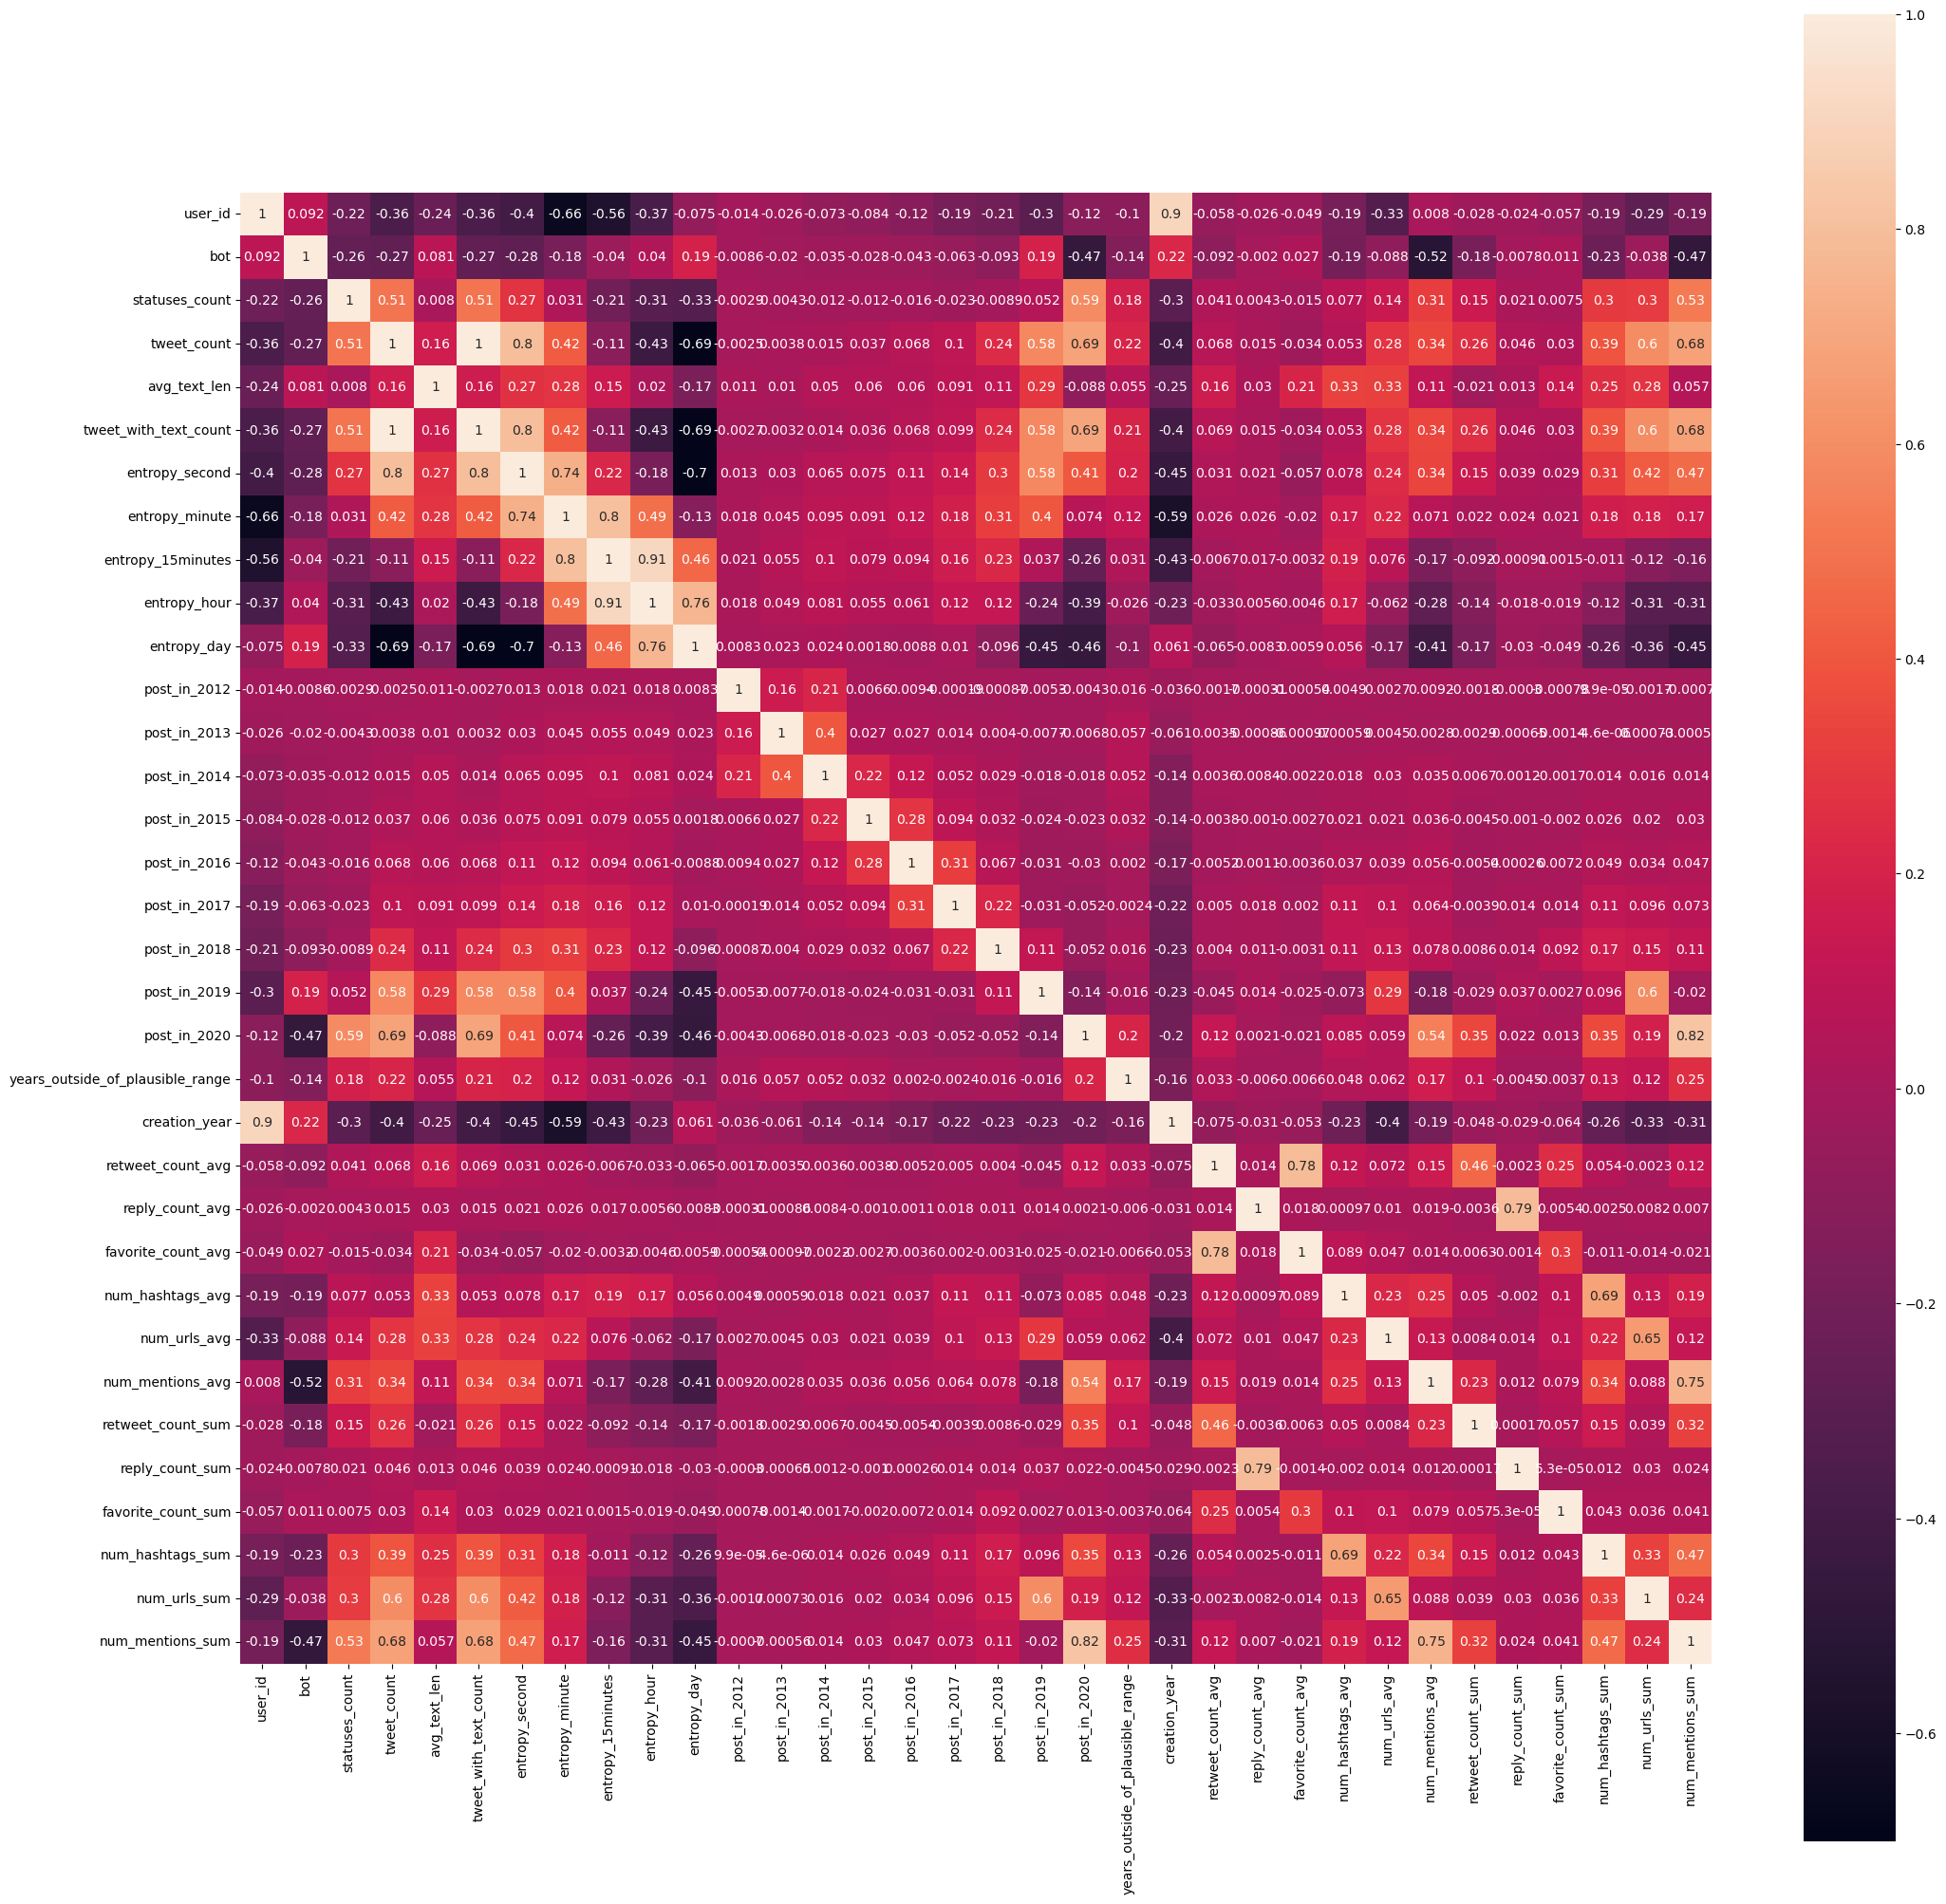

In [410]:
corr_matrix = df_users_indicators.corr()

fig, ax = plt.subplots(figsize=(25,25))         # Sample figsize in inches
mask = np.zeros_like(corr_matrix)
#mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sn.heatmap(corr_matrix, annot=True, mask=mask, square=True)

plt.show()

We discard the following features due to high correlation:
*   tweet_with_text_count
*   reply_count_sum
*   num_hashtags_sum
*   num_urls_sum
*   num_mentions_sum
*   retweet_count_avg
*   entropy_15minutes
*   entropy_second

A cause for elimination for one of a couple of indicators, in addition to high correlation, was also derivation from the same original feature.

## Remove highly correlated features

In [411]:
del df_users_indicators['tweet_with_text_count']
del df_users_indicators['reply_count_sum']
del df_users_indicators['num_hashtags_sum']
del df_users_indicators['num_urls_sum']
del df_users_indicators['num_mentions_sum']
del df_users_indicators['retweet_count_avg']

del df_users_indicators['entropy_second']
del df_users_indicators['entropy_minute'] 
#del df_users_indicators['entropy_15minutes']
del df_users_indicators['entropy_hour']
#del df_users_indicators['entropy_day']


Showing the new correlation matrix:

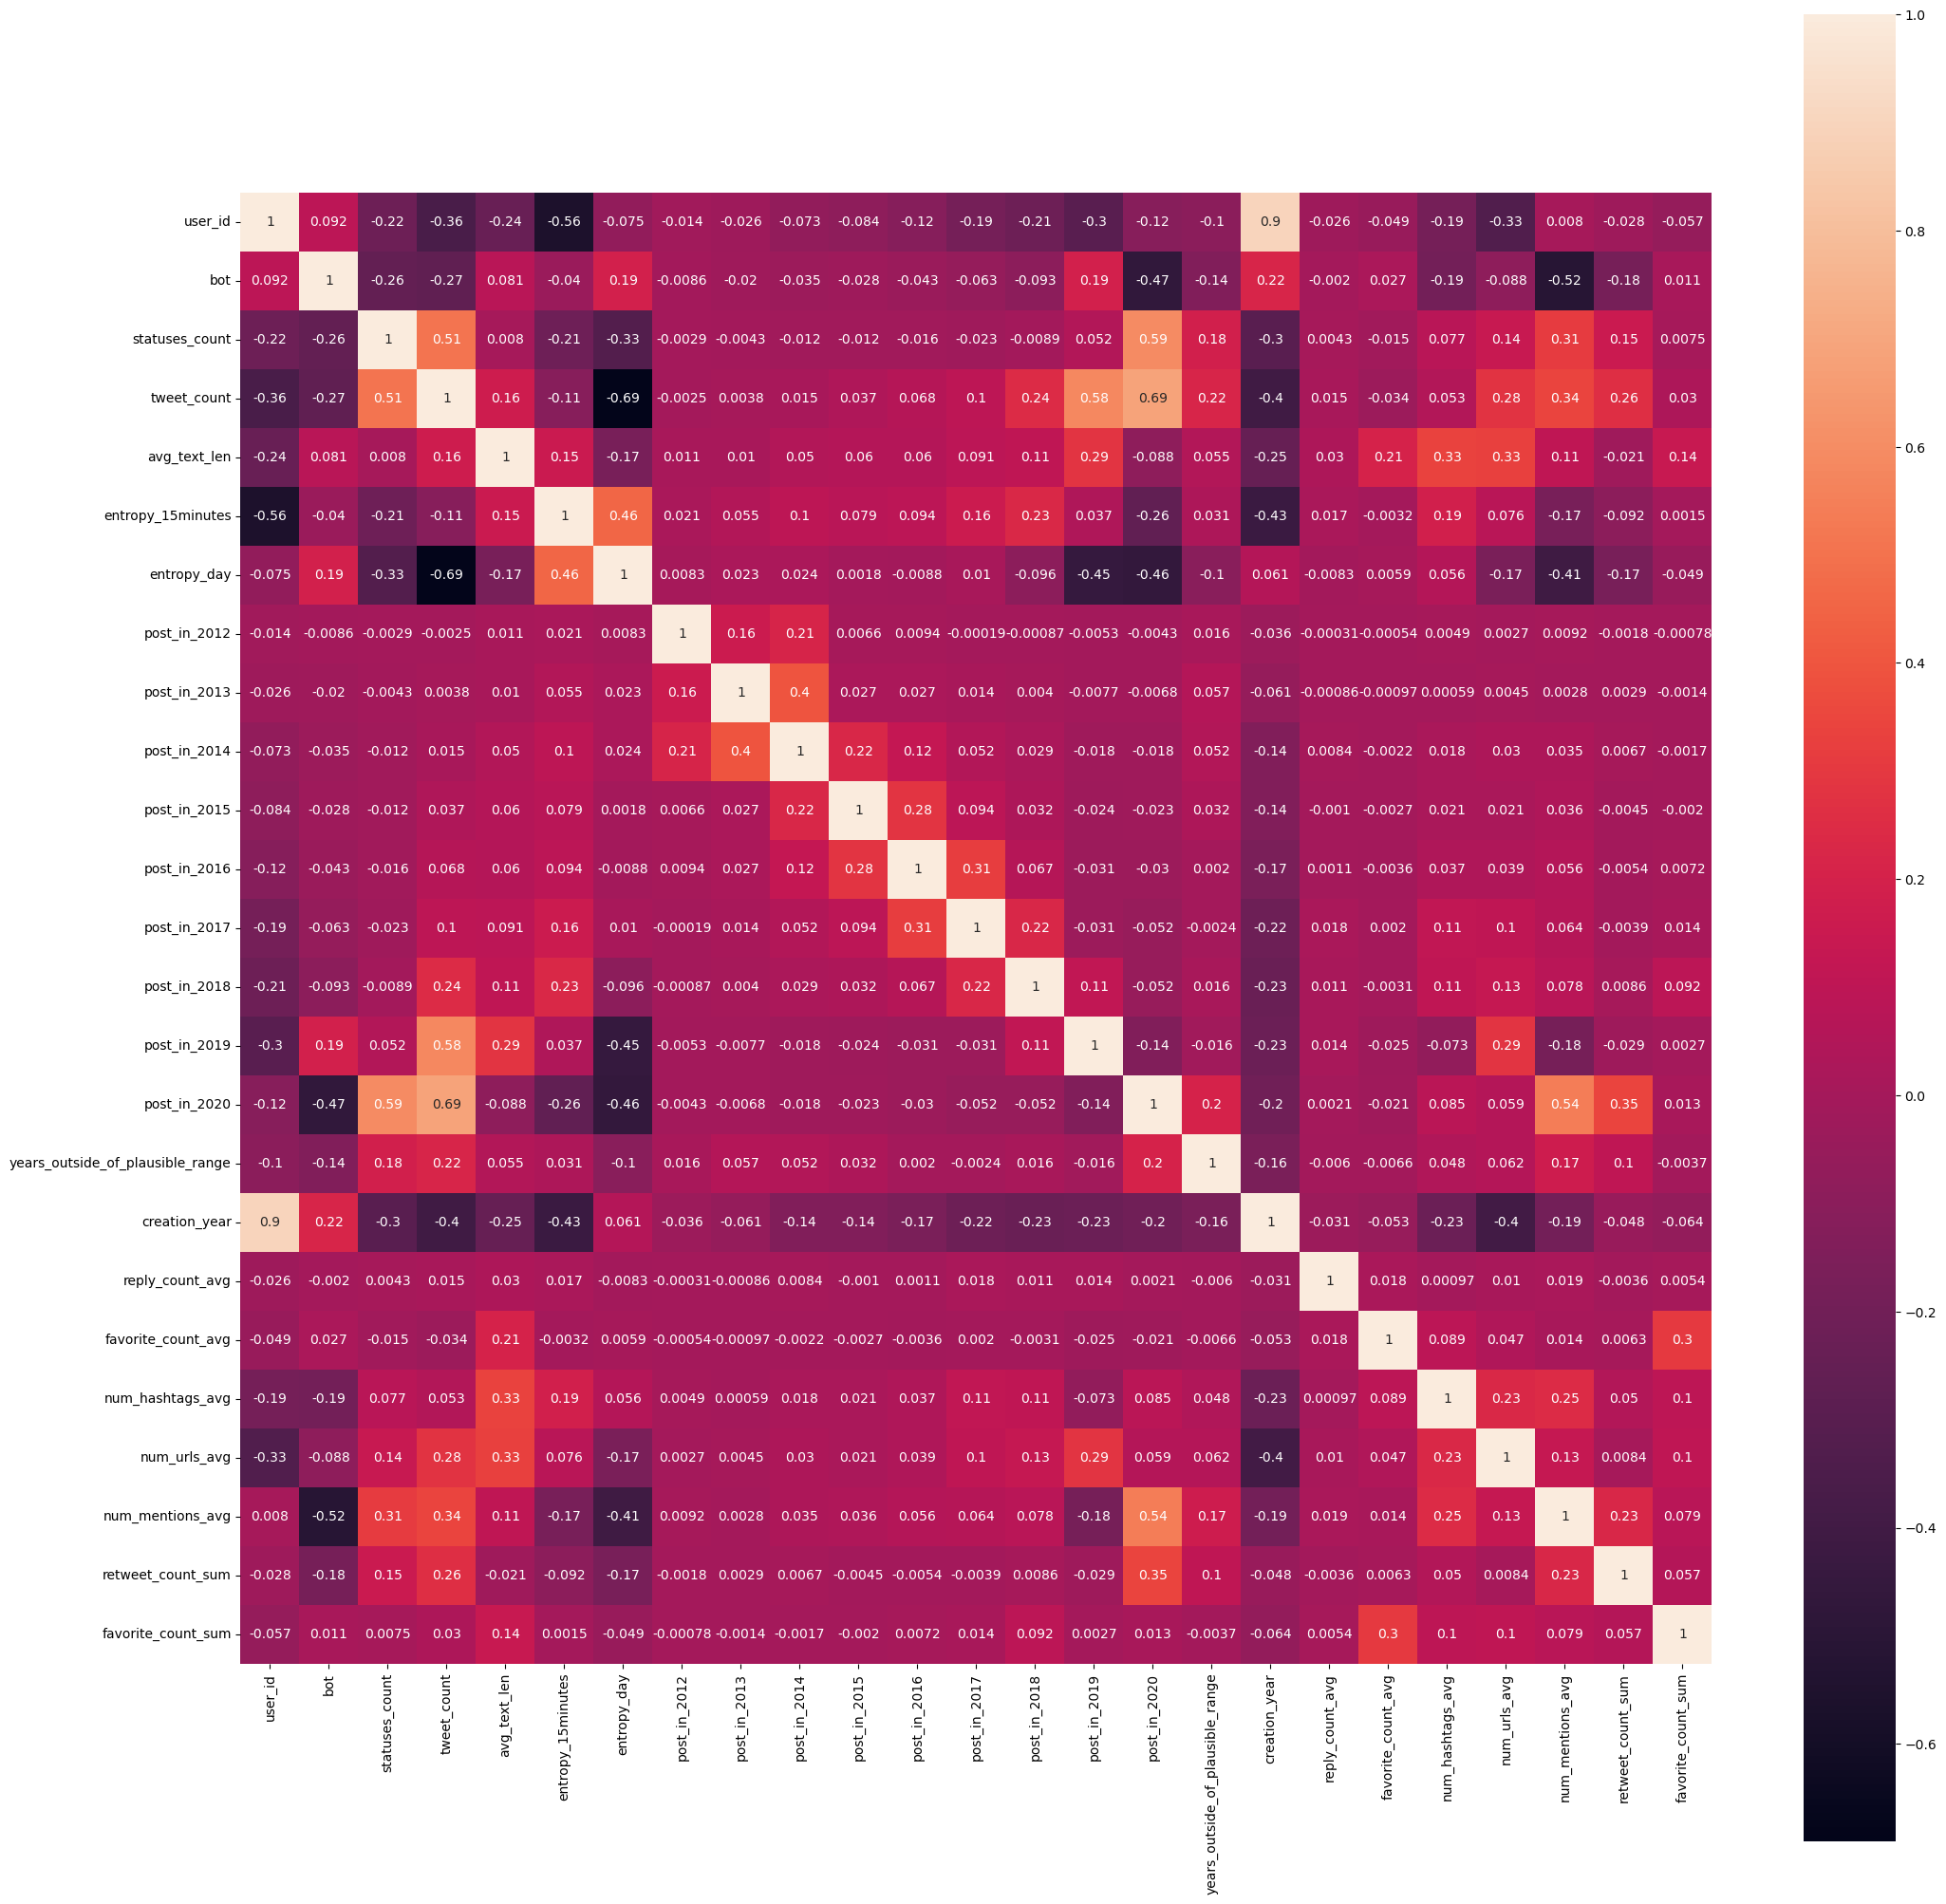

In [412]:
corr_matrix = df_users_indicators.corr()

fig, ax = plt.subplots(figsize=(25,25))         # Sample figsize in inches
mask = np.zeros_like(corr_matrix)
#mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sn.heatmap(corr_matrix, annot=True, mask=mask, square=True)

plt.show()

Setting the id column to 'user_id' and saving the final dataframe without the highly correlated features

In [413]:
df_users_indicators.set_index('user_id',inplace=True)
df_users_indicators.to_csv('../dataset/user_indicators_uncorrelated.csv')

Reading the csv to make sure that the dataframe is saved correctly

In [414]:
df_users_indicators = pd.read_csv('../dataset/user_indicators_uncorrelated.csv', sep=',', index_col=0)
df_users_indicators.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lang                              11508 non-null  object 
 1   bot                               11508 non-null  int64  
 2   created_at                        11508 non-null  object 
 3   statuses_count                    11508 non-null  int64  
 4   tweet_count                       11508 non-null  int64  
 5   avg_text_len                      11508 non-null  float64
 6   entropy_15minutes                 11508 non-null  float64
 7   entropy_day                       11508 non-null  float64
 8   post_in_2012                      11508 non-null  int64  
 9   post_in_2013                      11508 non-null  int64  
 10  post_in_2014                      11508 non-null  int64  
 11  post_in_2015                      11508 non-null  int6